In [16]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
from time import time
import re
import string
# operatating system library - using OS dependent functionality
import os
import emoji
# pretty print
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
# warnings.filterwarnings('ignore')

np.random.seed(37)

In [17]:
df = pd.read_csv('./Tweets.csv')
df = df.reindex(np.random.permutation(df.index))
df = df[['text', 'airline_sentiment']]

In [18]:
df

,text,airline_sentiment
10620,@USAirways told to work it out ourselves #joke #fail,negative
13609,@AmericanAir that all AA is for USAir Elite members. It's one big disappointment in the way we are treated. #epicfailure,negative
2955,@united Bummer. Might have to go with @AmericanAir card instead. TY for response though.,negative
3585,@united well the income flight to dca to take us to ewr was delayed and it made us miss our connection to FLL so yes hotels were necessary,negative
2087,@united we have tried to change our flight THREE times on the phone and got disconnected each time.,negative
...,...,...
988,@united done,neutral
14587,@AmericanAir I’ll play it by ear. I know that you are doing your best. Buy some chewey oatmeal cookies for your customer care folks.,negative
9036,"@USAirways I left my personal stuff on US4551 from PHL-BOS about an hour ago. Went baggage, was told plane left to call 800#",neutral
4459,"@SouthwestAir: Tried for VIP Live in The Vineyard but yr site went down, by the time I got in 2 redeem pts those packages gone.",negative


# Exploratory Data Analysis

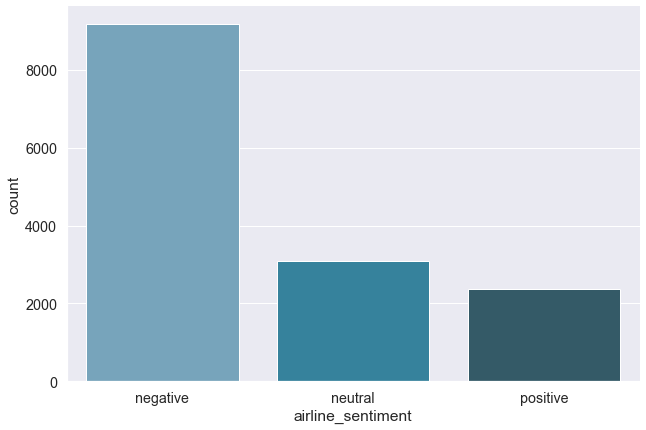

In [19]:
sns.catplot(x="airline_sentiment", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [20]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [21]:
tc = TextCounts()
df_eda = tc.fit_transform(df.text)
# Add airline_sentiment to df_eda
df_eda['airline_sentiment'] = df.airline_sentiment

In [22]:
df.text

10620                                                                                          @USAirways told to work it out ourselves #joke #fail
13609                      @AmericanAir that all AA is for USAir Elite members. It's one big disappointment in the way we are treated. #epicfailure
2955                                                       @united Bummer. Might have to go with @AmericanAir card instead. TY for response though.
3585     @united well the income flight to dca to take us to ewr was delayed and it made us miss our connection to FLL so yes hotels were necessary
2087                                            @united we have tried to change our flight THREE times on the phone and got disconnected each time.
                                                                            ...                                                                    
988                                                                                                             

In [23]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
negative           9178.0  20.387557  6.100020  2.0  17.0  22.0  25.0  35.0
neutral            3099.0  15.290094  7.150738  2.0  10.0  15.0  21.0  34.0
positive           2363.0  14.478206  7.266129  2.0   8.0  14.0  21.0  33.0


/Users/nicolaspetras/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/nicolaspetras/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


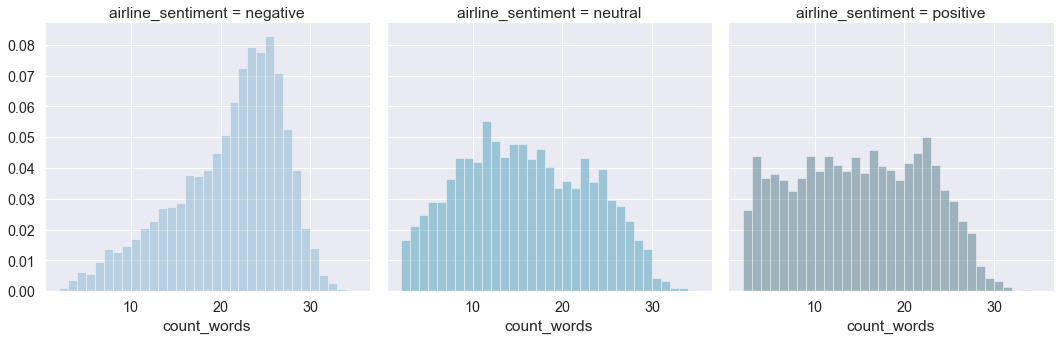

In [24]:
show_dist(df_eda, 'count_words')

# Cleaning the Text - Data Cleaning, Pre-processing

In [25]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [26]:
ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

12222                             glad rt bet bird wish flown south winter
3936        point upc code check baggag tell luggag vacat day tri swimsuit
367                                     vx jfk la dirti plane not standard
12257    tell mean work need estim time arriv pleas need laptop work thank
2957                    sure busi go els airlin travel name kathryn sotelo
Name: text, dtype: object

In [27]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

22 records have no words left after text cleaning


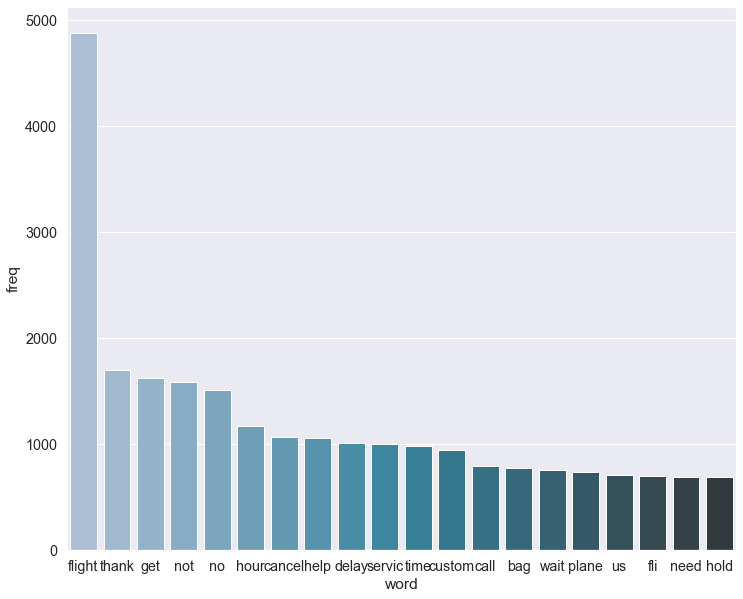

In [28]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

# Creating the Test Data

In [32]:
df_eda

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,airline_sentiment,clean_text
10620,9,1,2,0,0,0,0,negative,told work joke fail
13609,21,1,1,1,0,0,0,negative,aa usair elit member one big disappoint way treat epicfailur
2955,14,2,0,1,0,0,0,negative,bummer might go card instead ty respons though
3585,28,1,0,1,0,0,0,negative,well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari
2087,18,1,0,1,0,0,0,negative,tri chang flight three time phone got disconnect time
...,...,...,...,...,...,...,...,...,...
988,2,1,0,0,0,0,0,neutral,done
14587,25,1,0,0,0,0,0,negative,i’ll play ear know best buy chewey oatmeal cooki custom care folk
9036,24,1,0,2,0,0,0,neutral,left person stuff us phl bo hour ago went baggag told plane left call
4459,25,1,0,1,0,0,0,negative,tri vip live vineyard yr site went time got redeem pt packag gone


In [35]:
sr_clean

10620                                                                    told work joke fail
13609                           aa usair elit member one big disappoint way treat epicfailur
2955                                          bummer might go card instead ty respons though
3585     well incom flight dca take us ewr delay made us miss connect fll ye hotel necessari
2087                                   tri chang flight three time phone got disconnect time
                                                ...                                         
988                                                                                     done
14587                      i’ll play ear know best buy chewey oatmeal cooki custom care folk
9036                   left person stuff us phl bo hour ago went baggag told plane left call
4459                       tri vip live vineyard yr site went time got redeem pt packag gone
1935                                                                  

In [30]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'airline_sentiment',
 'clean_text']

In [33]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size=0.1, random_state=37)